## OpenDP Relative Risk - Trying out stuff in Python

Just a simple pipeline

In [1]:
import opendp.prelude as dp
dp.enable_features("contrib")

d_in = 1 # input distance
input_metric = dp.symmetric_distance()

d_out = 1 # epsilon
privacy_measure = dp.max_divergence(T=float) # pure dp

# We don't really use what's left below in this code box
######################################################################################

col_names = [
   "name", "sex", "age", "maritalStatus", "hasChildren", "highestEducationLevel", 
   "sourceOfStress", "smoker", "optimism", "lifeSatisfaction", "selfEsteem"
]

import urllib.request
data_url = "https://raw.githubusercontent.com/opendp/opendp/sydney/teacher_survey.csv"
with urllib.request.urlopen(data_url) as data_req:
    data = data_req.read().decode('utf-8')

# Make a queriable
m_sc = dp.c.make_sequential_composition(
    # data set is a single string, with rows separated by linebreaks
    input_domain=dp.atom_domain(T=str),
    input_metric=input_metric,
    output_measure=privacy_measure,
    d_in=d_in,
    d_mids=[d_out / 3] * 3,
)

qbl_sc = m_sc(data)

A transformation and two possible mechanisms

In [2]:
import opendp as dpf

# Make a query
count_transformation = (
    dp.t.make_split_dataframe(",", col_names=col_names)
    >> dp.t.make_select_column("age", str)
    >> dp.t.then_count()
)
count_sensitivity = count_transformation.map(d_in)

# Add a Laplace measurement
laplace_scale = 1.0
count_laplace_measurement = count_transformation >> dp.m.then_laplace(scale=laplace_scale)
epsilon_laplace = count_laplace_measurement.map(count_sensitivity)
count_laplace_smooth_max_divergence_ms = dpf.combinators.make_zCDP_to_approxDP(dpf.combinators.make_pureDP_to_zCDP(count_laplace_measurement))
laplace_smd_curve = count_laplace_smooth_max_divergence_ms.map(count_sensitivity)

# Add a Gaussian measurement, transform to approximate DP and get SMDCurve
gaussian_scale = 1.0
count_gaussian_measurement = count_transformation >> dp.m.then_gaussian(scale = gaussian_scale)
count_gaussian_smooth_max_divergence_ms = dpf.combinators.make_zCDP_to_approxDP(count_gaussian_measurement)
gaussian_smd_curve = count_gaussian_smooth_max_divergence_ms.map(count_sensitivity)

Building blocks:
- Support f-DP curves: $f_{ε,δ}(α) = max \{0, 1 − δ − e^εα, e^{−ε}(1 − δ − α)\}$
- F-DP curve: $ f = \sup_{i∈I} f_{ε_i, δ_i}$

In [3]:
%load_ext autoreload
%autoreload 2

from tradeoff import (
    support_tradeoff,
    approx_tradeoff, # alpha(beta), given n (epsilon, delta) pairs
    tradeoffCurve,   # alpha(beta), given privacy profile (computes then caches epsilon delta pairs),
    smdCurveWrapper  # utility for wrapping smdCurves
)

Analytic versions f-DP functions

- Gaussian mechanism:
        $G_μ(α) = Φ(Φ^{−1}(1 − α) − μ)$ with $scale = \sqrt{sens(θ)^2/μ^2}$ meaning $\mu = \frac{sens(\theta)}{scale}$
- Laplace mechanism:
        $F-DP_{Laplace} = CDF_{Laplace}(CDF^{-1}_{Laplace}((1 - \alpha) - \mu)$

In [4]:
import scipy

from tradeoff import (
   tradeoff_gaussian,           # analytical gaussian tradeoff
   tradeoff_laplace,            # analytical laplace tradeoff
   get_tradeoff_gaussian,       # wrappers
   get_tradeoff_laplace,
   get_gaussian_privacy_profile, # analytical delta(epsilon)
   tradeoff_opt_gaussian          # optimization of the gaussian dual
)

In [5]:
import sys
import numpy as np
sys.path.append("../discrete-gaussian-differential-privacy")
from cdp2adp import (
    dg_delta
)
from tradeoff import dg_delta_k

alphas = np.arange(0, 1, 0.01)
deltas = np.arange(0.001, 1, 0.001)
privacy_profile_deltas = np.arange(0.01, 1, 0.01)
epsilons = np.concatenate((np.arange(0, 3, 0.01), np.arange(3, 30, 0.1)))

Plot the stuff

In [6]:
gaussian_mu = count_sensitivity / gaussian_scale

betas_gaussian_001 = tradeoffCurve(smdCurveWrapper(gaussian_smd_curve), deltas=privacy_profile_deltas)(alphas)
#betas_gaussian_00001 = tradeoffCurve(smdCurveWrapper(gaussian_smd_curve), deltas=np.arange(0.00001, 1, 0.00001))(alphas)
betas_gaussian_analytical = [tradeoff_gaussian(alpha, gaussian_mu) for alpha in alphas]
betas_gaussian_approx = tradeoffCurve(get_gaussian_privacy_profile(count_sensitivity, gaussian_scale), epsilons=epsilons)(alphas)
#betas_gaussian_approx_optimization = [tradeoff_opt_gaussian(alpha, get_gaussian_privacy_profile(count_sensitivity, gaussian_scale)) for alpha in alphas]
betas_gaussian_dg_analytical = [tradeoffCurve((lambda e: dg_delta(gaussian_scale**2, e, count_sensitivity)), epsilons=epsilons)(alpha) for alpha in alphas]
betas_gaussian_dg_analytical_k = [tradeoffCurve((lambda e: dg_delta_k(gaussian_scale**2, e, count_sensitivity, k=-4)), epsilons=epsilons)(alpha) for alpha in alphas]

privacy_profile_gaussian_approx_epsilons = [gaussian_smd_curve.epsilon(delta) for delta in privacy_profile_deltas]
privacy_profile_gaussian_analytical_deltas = [get_gaussian_privacy_profile(count_sensitivity, gaussian_scale)(eps) for eps in epsilons]
privacy_profile_gaussian_discrete_deltas = [(lambda e: dg_delta(gaussian_scale**2, e, count_sensitivity, iters=2000))(eps) for eps in epsilons]
privacy_profile_gaussian_discrete_deltas_k = [(lambda e: dg_delta_k(gaussian_scale**2, e, count_sensitivity, iters=2000, k=-4))(eps) for eps in epsilons]

/tmp/ipykernel_133353/3956227315.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend()


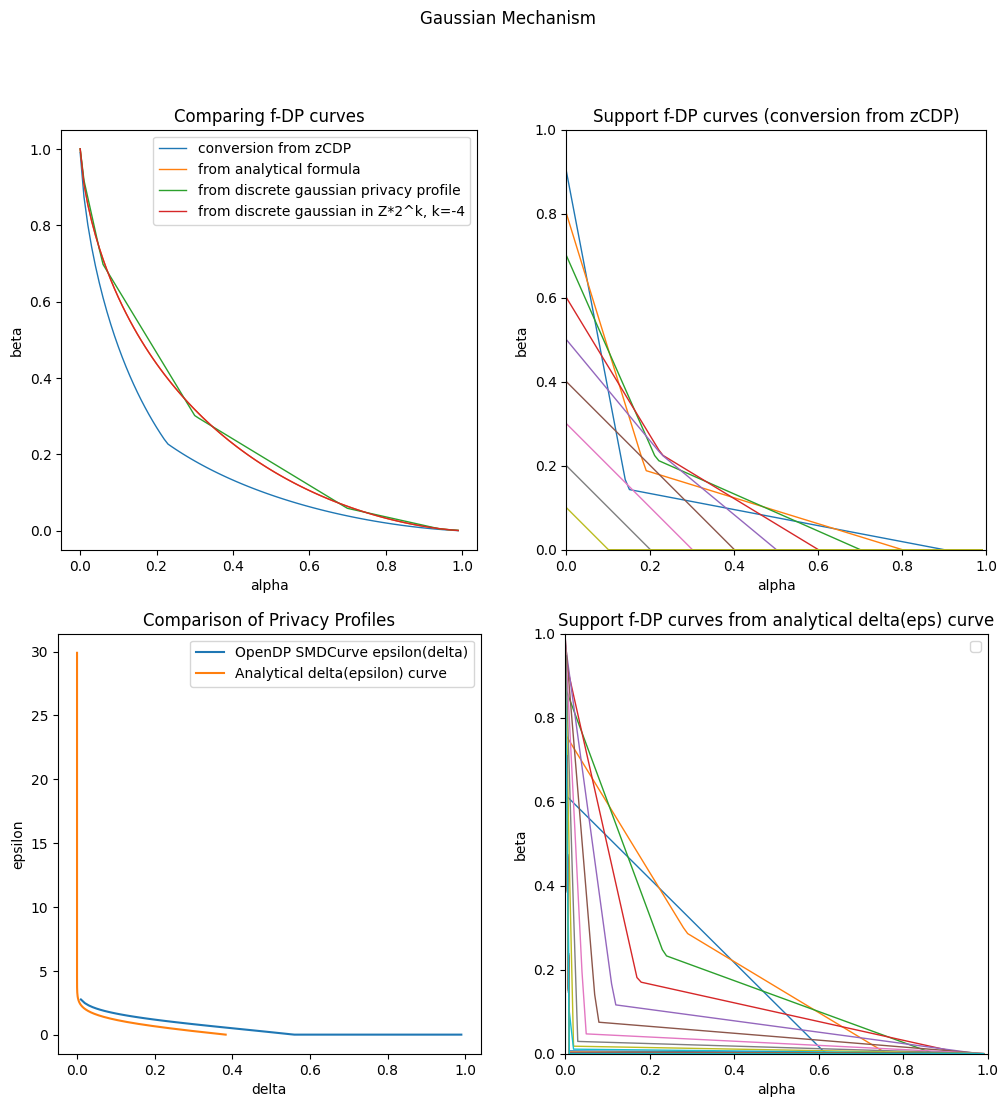

In [7]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Gaussian Mechanism")

# from smdCurve vs analytical
ax1.plot(alphas, betas_gaussian_001, label='conversion from zCDP', marker='', linewidth=1)
#ax1.plot(alphas, betas_gaussian_00001, label='from smdCurve, delta_incr=0.00001', marker='', linewidth=1)
#ax1.plot(alphas, betas_gaussian_approx, label='approx from delta(epsilon) curve', marker='', linewidth=1)
ax1.plot(alphas, betas_gaussian_analytical, label='from analytical formula', marker='', linewidth=1)
ax1.plot(alphas, betas_gaussian_dg_analytical, label='from discrete gaussian privacy profile', marker='', linewidth=1)
ax1.plot(alphas, betas_gaussian_dg_analytical_k, label='from discrete gaussian in Z*2^k, k=-4', marker='', linewidth=1)
#ax1.plot(alphas, betas_gaussian_approx_optimization, label="from optimization of dual", marker="", linewidth=1)

ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
ax1.set_title('Comparing f-DP curves')
ax1.legend()
ax1.set_aspect('equal')

# Support lines
for delta in np.arange(0.1, 1, 0.1):
    betas_eps_delta = [support_tradeoff(alpha, gaussian_smd_curve.epsilon(delta), delta) for alpha in alphas]
    ax2.plot(alphas, betas_eps_delta, label=f"f-eps-delta({delta})", marker="", linewidth=1)
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title('Support f-DP curves (conversion from zCDP)')
#ax2.legend()
ax2.set_aspect('equal')

ax3.plot(privacy_profile_deltas, privacy_profile_gaussian_approx_epsilons, label="OpenDP SMDCurve epsilon(delta)")
ax3.plot(privacy_profile_gaussian_analytical_deltas, epsilons , label="Analytical delta(epsilon) curve")
#ax3.plot(privacy_profile_gaussian_discrete_deltas, epsilons , label="Discrete Gaussian delta(epsilon) curve")
#ax3.plot(privacy_profile_gaussian_discrete_deltas_k, epsilons , label="Discrete Gaussian delta(epsilon) curve in z*2^k, k=-4")
ax3.set_xlabel("delta")
ax3.set_ylabel("epsilon")
ax3.set_title("Comparison of Privacy Profiles")
ax3.legend()

for eps in np.arange(0, 30, 0.5):
    betas_delta_eps = [support_tradeoff(alpha, eps, get_gaussian_privacy_profile(count_sensitivity, gaussian_scale)(eps)) for alpha in alphas]
    ax4.plot(alphas, betas_delta_eps, marker="", linewidth=1)
ax4.set_xlabel("alpha")
ax4.set_ylabel("beta")
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.set_title("Support f-DP curves from analytical delta(eps) curve")
ax4.legend()

plt.show()


Discrete Gaussian Mechanism delta(epsilon) curve. Points of discontinuity are due to the discrete nature of the noise applied (see lower limit and upper limit in algorithm).

In [8]:
from tradeoff import dg_delta_k
privacy_profile_gaussian_discrete_deltas_explore = [(lambda e: dg_delta(gaussian_scale**2, e, count_sensitivity, iters=2000))(eps) for eps in np.arange(0.001, 3, 0.001)]
privacy_profile_gaussian_discrete_deltas_k1 = [(lambda e: dg_delta_k(gaussian_scale**2, e, count_sensitivity, iters=2000, k=-1))(eps) for eps in np.arange(0.001, 3, 0.001)]
privacy_profile_gaussian_discrete_deltas_k2 = [(lambda e: dg_delta_k(gaussian_scale**2, e, count_sensitivity, iters=2000, k=-2))(eps) for eps in np.arange(0.001, 3, 0.001)]
privacy_profile_gaussian_discrete_deltas_k4 = [(lambda e: dg_delta_k(gaussian_scale**2, e, count_sensitivity, iters=2000, k=-4))(eps) for eps in np.arange(0.001, 3, 0.001)]


[]

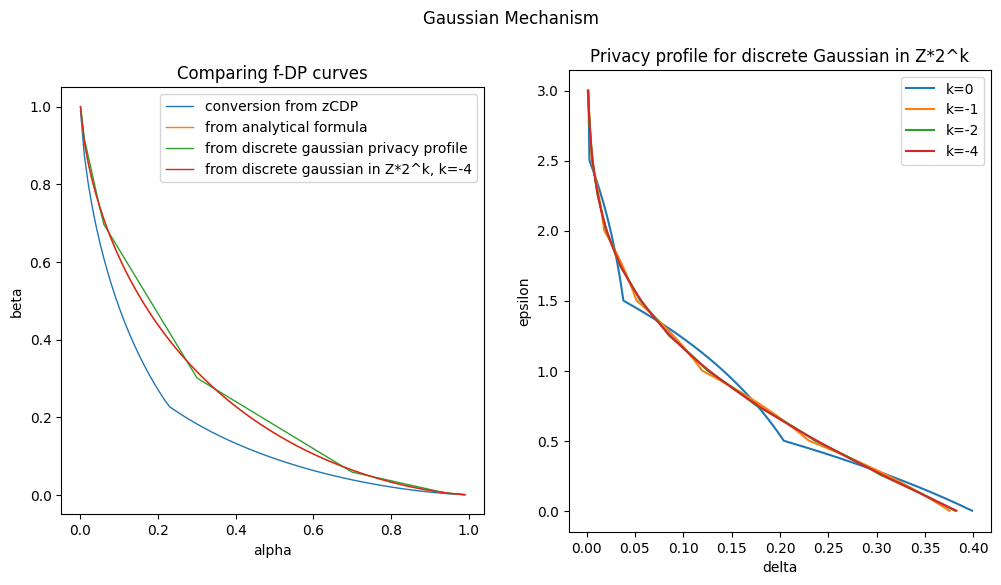

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Gaussian Mechanism")

# from smdCurve vs analytical
ax1.plot(alphas, betas_gaussian_001, label='conversion from zCDP', marker='', linewidth=1)
#ax1.plot(alphas, betas_gaussian_00001, label='from smdCurve, delta_incr=0.00001', marker='', linewidth=1)
#ax1.plot(alphas, betas_gaussian_approx, label='approx from delta(epsilon) curve', marker='', linewidth=1)
ax1.plot(alphas, betas_gaussian_analytical, label='from analytical formula', marker='', linewidth=1)
ax1.plot(alphas, betas_gaussian_dg_analytical, label='from discrete gaussian privacy profile', marker='', linewidth=1)
ax1.plot(alphas, betas_gaussian_dg_analytical_k, label='from discrete gaussian in Z*2^k, k=-4', marker='', linewidth=1)
#ax1.plot(alphas, betas_gaussian_approx_optimization, label="from optimization of dual", marker="", linewidth=1)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
ax1.set_title('Comparing f-DP curves')
ax1.legend()
ax1.set_aspect('equal')


ax2.set_title("Privacy profile for discrete Gaussian in Z*2^k")
ax2.plot(privacy_profile_gaussian_discrete_deltas_explore, np.arange(0.001, 3, 0.001), label="k=0")
ax2.plot(privacy_profile_gaussian_discrete_deltas_k1, np.arange(0.001, 3, 0.001), label="k=-1")
ax2.plot(privacy_profile_gaussian_discrete_deltas_k2, np.arange(0.001, 3, 0.001), label="k=-2")
ax2.plot(privacy_profile_gaussian_discrete_deltas_k4, np.arange(0.001, 3, 0.001), label="k=-4")
ax2.set_xlabel("delta")
ax2.set_ylabel("epsilon")
ax2.legend()

plt.plot()

Posterior: $p_{posterior} = \frac{1 - \beta(\alpha)}{(1-p_{prior})\alpha + p_{prior}(1 - \beta(\alpha))}p_{prior}$

In [10]:
from relative_risk import posterior

priors = [0.1, 0.2, 0.5, 0.9, 0.99]

In [11]:
tradeoff_approx_gaussian = tradeoffCurve(smdCurveWrapper(gaussian_smd_curve), deltas=deltas)
posteriors_gaussian = []
for prior in priors:
    post = [posterior(alpha, tradeoff_approx_gaussian, prior) for alpha in alphas]
    posteriors_gaussian.append(post)

posteriors_analytical_gaussian = []
for prior in priors:
    post = [posterior(alpha, get_tradeoff_gaussian(mu=gaussian_mu), prior) for alpha in alphas]
    posteriors_analytical_gaussian.append(post)

tradeoff_discrete_gaussian = tradeoffCurve((lambda e: dg_delta(gaussian_scale**2, e, count_sensitivity, iters=2000)), epsilons=epsilons)
posteriors_discrete_gaussian = []
for prior in priors:
    post = [posterior(alpha, tradeoff_discrete_gaussian, prior) for alpha in alphas]
    posteriors_discrete_gaussian.append(post)

tradeoff_discrete_gaussian_k4 = tradeoffCurve((lambda e: dg_delta_k(gaussian_scale**2, e, count_sensitivity, iters=2000, k=-4)), epsilons=epsilons)
posteriors_discrete_gaussian_4k = []
for prior in priors:
    post = [posterior(alpha, tradeoff_discrete_gaussian_k4, prior) for alpha in alphas]
    posteriors_discrete_gaussian_4k.append(post)

/mnt/data/research/opendp/opendp-relative-risk/relative_risk.py:5: RuntimeWarning: invalid value encountered in scalar divide
  posterior = (prior * (1 - beta)) / ((1 - prior)*alpha + prior * (1 - beta))


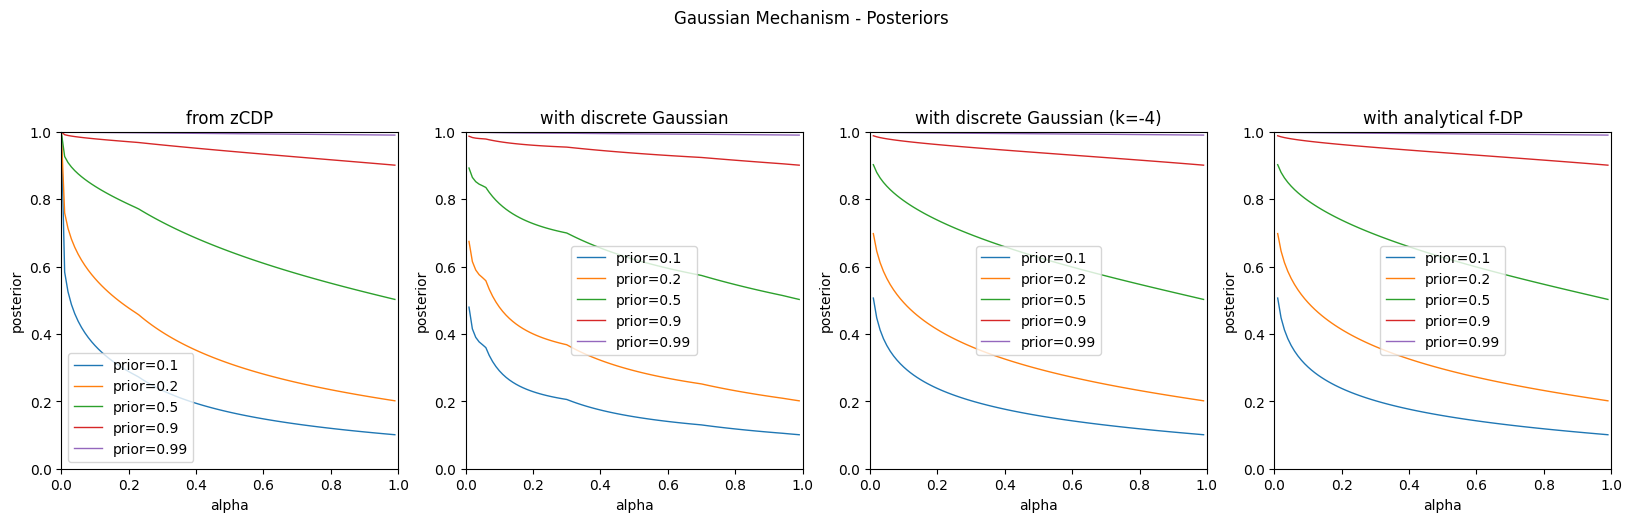

In [12]:
import matplotlib.pyplot as plt

fig, ((ax1, ax3, ax4, ax2)) = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle("Gaussian Mechanism - Posteriors")

ax1.set_title('from zCDP')
for i in range(0, len(posteriors_gaussian)):
    ax1.plot(alphas, posteriors_gaussian[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax1.set_xlabel('alpha')
ax1.set_ylabel('posterior')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_aspect('equal')

ax2.set_title('with analytical f-DP')
for i in range(0, len(posteriors_gaussian)):
    ax2.plot(alphas, posteriors_analytical_gaussian[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax2.set_xlabel('alpha')
ax2.set_ylabel('posterior')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_aspect('equal')

ax3.set_title('with discrete Gaussian')
for i in range(0, len(posteriors_gaussian)):
    ax3.plot(alphas, posteriors_discrete_gaussian[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax3.set_xlabel('alpha')
ax3.set_ylabel('posterior')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.legend()
ax3.set_aspect('equal')

ax4.set_title('with discrete Gaussian (k=-4)')
for i in range(0, len(posteriors_gaussian)):
    pass
    ax4.plot(alphas, posteriors_discrete_gaussian_4k[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax4.set_xlabel('alpha')
ax4.set_ylabel('posterior')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.legend()
ax4.set_aspect('equal')

plt.show()

Relative risk:
- Relative risk: $relrisk = \frac{prior}{posterior}$
- Maximum relative risk: $\rho = sup_{\alpha, prior} \frac{prior}{posterior}$

In [13]:
from relative_risk import relative_risk

In [14]:
alphas = np.arange(0, 1, 0.01)
deltas = np.arange(0.001, 1, 0.001)
epsilons = np.concatenate((np.arange(0, 3, 0.001), np.arange(3, 30, 0.1)))

priors = [0.1, 0.2, 0.5, 0.9, 0.99]

tradeoff_approx_gaussian = tradeoffCurve(smdCurveWrapper(gaussian_smd_curve), deltas=deltas)
rrisk_gaussian = []
for prior in priors:
    rrsisk = [relative_risk(alpha, tradeoff_approx_gaussian, prior) for alpha in alphas]
    rrisk_gaussian.append(rrsisk)

rrisk_analytical_gaussian = []
for prior in priors:
    rrsisk = [relative_risk(alpha, get_tradeoff_gaussian(mu=gaussian_mu), prior) for alpha in alphas]
    rrisk_analytical_gaussian.append(rrsisk)

tradeoff_discrete_gaussian = tradeoffCurve((lambda e: dg_delta(gaussian_scale**2, e, count_sensitivity, iters=2000)), epsilons=epsilons)
rrisk_discrete_gaussian = []
for prior in priors:
    rrsisk = [relative_risk(alpha, tradeoff_discrete_gaussian, prior) for alpha in alphas]
    rrisk_discrete_gaussian.append(rrsisk)

tradeoff_discrete_gaussian_k4 = tradeoffCurve((lambda e: dg_delta_k(gaussian_scale**2, e, count_sensitivity, iters=2000, k=-4)), epsilons=epsilons)
rrisk_discrete_gaussian_k4 = []
for prior in priors:
    rrsisk = [relative_risk(alpha, tradeoff_discrete_gaussian_k4, prior) for alpha in alphas]
    rrisk_discrete_gaussian_k4.append(rrsisk)

/mnt/data/research/opendp/opendp-relative-risk/relative_risk.py:12: RuntimeWarning: invalid value encountered in scalar divide
  relative_risk = (1 - beta) / ((1 - prior)*alpha + prior * (1 - beta))


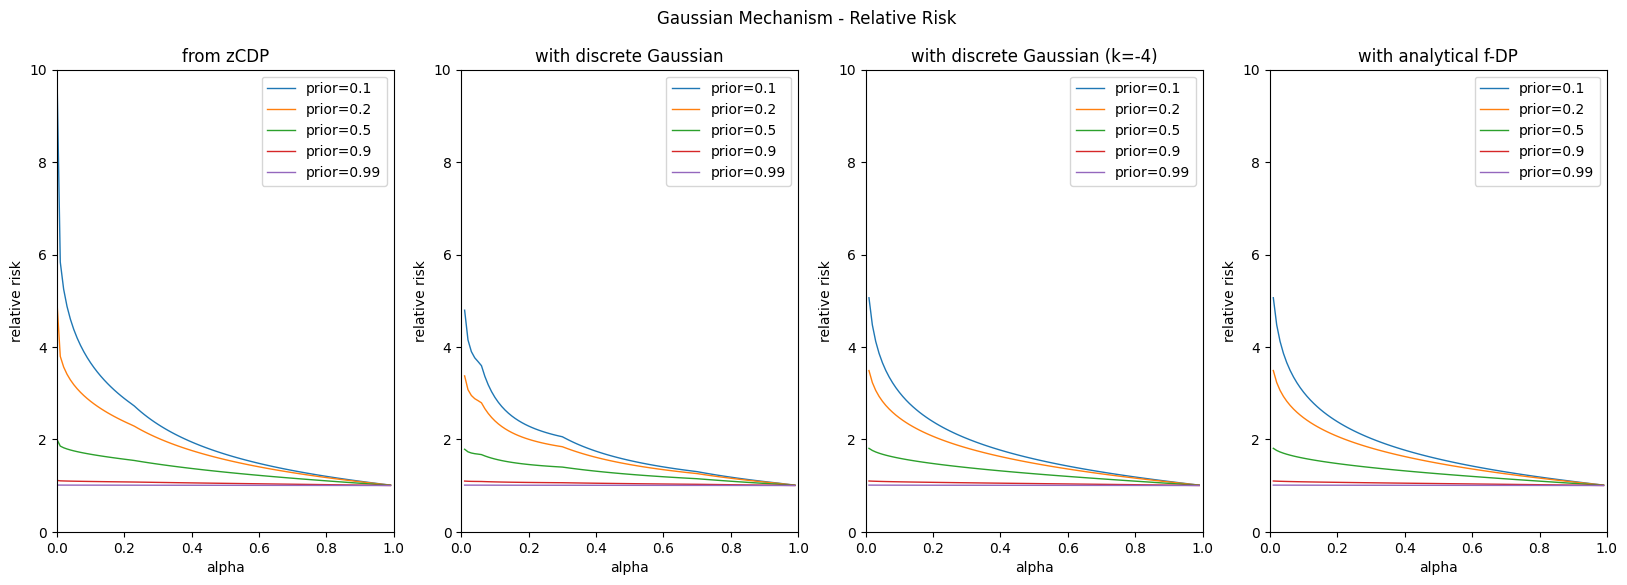

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax3, ax4, ax2) = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle("Gaussian Mechanism - Relative Risk")

ax1.set_title('from zCDP')
for i in range(0, len(rrisk_gaussian)):
    ax1.plot(alphas, rrisk_gaussian[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax1.set_xlabel('alpha')
ax1.set_ylabel('relative risk')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 10)
#ax1.set_aspect('equal')

ax2.set_title('with analytical f-DP')
for i in range(0, len(rrisk_gaussian)):
    ax2.plot(alphas, rrisk_analytical_gaussian[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax2.set_xlabel('alpha')
ax2.set_ylabel('relative risk')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 10)
ax2.legend()
#ax2.set_aspect('equal')

ax3.set_title('with discrete Gaussian')
for i in range(0, len(rrisk_gaussian)):
    ax3.plot(alphas, rrisk_discrete_gaussian[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax3.set_xlabel('alpha')
ax3.set_ylabel('relative risk')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 10)
ax3.legend()
#ax3.set_aspect('equal')

ax4.set_title('with discrete Gaussian (k=-4)')
for i in range(0, len(posteriors_gaussian)):
    ax4.plot(alphas, rrisk_discrete_gaussian_k4[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax4.set_xlabel('alpha')
ax4.set_ylabel('relative risk')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 10)
ax4.legend()
#ax4.set_aspect('equal')

plt.show()

## Laplace

In [16]:
from tradeoff import pure_dp_privacy_profile, get_laplace_privacy_profile

betas_laplace_001 = tradeoffCurve(smdCurveWrapper(laplace_smd_curve), deltas=privacy_profile_deltas)(alphas)
betas_laplace_analytical = [tradeoff_laplace(alpha, laplace_scale, count_sensitivity) for alpha in alphas]
meier_epsilons = np.arange(0.5, 1.5, 0.001)
betas_laplace_meier_conversion = tradeoffCurve((lambda e: pure_dp_privacy_profile(epsilon_laplace, e)), epsilons=meier_epsilons)(alphas)
betas_laplace_support_curve = [support_tradeoff(alpha, epsilon_laplace, 0) for alpha in alphas]
betas_laplace_privacy_profile = tradeoffCurve(get_laplace_privacy_profile(count_sensitivity, laplace_scale), epsilons=epsilons)(alphas)

privacy_profile_laplace_approx_epsilons = [laplace_smd_curve.epsilon(delta) for delta in privacy_profile_deltas]
#privacy_profile_gaussian_analytical_deltas = [get_gaussian_privacy_profile(count_sensitivity, gaussian_scale)(eps) for eps in epsilons]

In [17]:
#alphas = np.arange(0, 1, 0.01)


In [18]:
"""
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Laplace Mechanism - privacy profile")

# from smdCurve vs analytical
epsilon_laplace = 1.0
import math
import numpy as np
def pure_dp_privacy_profile_(delta):
    return math.log(math.exp(epsilon_laplace) - delta) if delta != 0 else epsilon_laplace

epsilons_pure_dp = [pure_dp_privacy_profile_(delta) for delta in np.arange(0, 1, 0.01)]
from tradeoff import pure_dp_privacy_profile
deltas_pure_dp = [pure_dp_privacy_profile(epsilon_laplace, epsilon) for epsilon in np.arange(0, 1, 0.1)]

ax1.plot(np.arange(0, 1, 0.01), epsilons_pure_dp, label='pure_dp_privacy_profile', marker='', linewidth=1)
ax1.plot(deltas_pure_dp, np.arange(0, 1, 0.1), label='pure_dp_privacy_profile', marker='', linewidth=1)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 10)
ax1.set_title('Comparing f-DP curves')
ax1.legend()

numbers = [
    1.0003383197422995, 0.973152118260286, 0.9459659167782726, 0.9187797152962591, 0.8915935138142457,
    0.8644073123322322, 0.8372211108502188, 0.8100349093682053, 0.7828487078861919, 0.7556625064041784,
    0.728476304922165, 0.7012901034401515, 0.6741039019581381, 0.6469177004761246, 0.6197314989941112,
    0.5925452975120977, 0.5653590960300843, 0.5381728945480708, 0.5109866930660575, 0.48380049158404403,
    0.4566142901020306, 0.42942808862001713, 0.4022418871380037, 0.37505568565599023, 0.3478694841739768,
    0.32068328269196333, 0.2934970812099499, 0.2686430173871461, 0.2649646807844338, 0.2612863441817216,
    0.2576080075790093, 0.2539296709762971, 0.2502513343735848, 0.24657299777087258, 0.2428946611681603,
    0.2392163245654481, 0.23553798796273587, 0.2318596513600236, 0.22818131475731135, 0.2245029781545991,
    0.22082464155188686, 0.21714630494917464, 0.2134679683464624, 0.20978963174375015, 0.2061112951410379,
    0.20243295853832563, 0.19875462193561338, 0.19507628533290114, 0.1913979487301889, 0.18771961212747665,
    0.1840412755247644, 0.18036293892205213, 0.17668460231933988, 0.17300626571662764, 0.1693279291139154,
    0.16564959251120315, 0.1619712559084909, 0.15829291930577868, 0.15461458270306644, 0.15093624610035417,
    0.14725790949764192, 0.14357957289492967, 0.13990123629221743, 0.13622289968950518, 0.13254456308679294,
    0.12886622648408066, 0.12518788988136842, 0.12147410484477542, 0.11779561981555228, 0.11411713478632919,
    0.11043864975710604, 0.10676016472788291, 0.10308167969865978, 0.09940319466943665, 0.09572470964021351,
    0.09204622461099038, 0.08836773958176723, 0.0846892545525441, 0.08101076952332097, 0.07733228449409783,
    0.0736537994648747, 0.06997531443565157, 0.06629682940642846, 0.06261834437720533, 0.058939859347982196,
    0.05526137431875906, 0.05158288928953593, 0.04790440426031279, 0.04422591923108966, 0.040547434201866524,
    0.036868949172643384, 0.03319046414342025, 0.029511979114197118, 0.02583349408497398, 0.022155009055750886,
    0.018476524026527753, 0.014798038997304617, 0.011119553968081482, 0.0074410689388583464, 0.0037625839096352112,
    0.00008409888041207605
]
ax2.plot(np.arange(0, 1.01, 0.01), numbers)"""

'\nimport matplotlib.pyplot as plt\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))\nfig.suptitle("Laplace Mechanism - privacy profile")\n\n# from smdCurve vs analytical\nepsilon_laplace = 1.0\nimport math\nimport numpy as np\ndef pure_dp_privacy_profile_(delta):\n    return math.log(math.exp(epsilon_laplace) - delta) if delta != 0 else epsilon_laplace\n\nepsilons_pure_dp = [pure_dp_privacy_profile_(delta) for delta in np.arange(0, 1, 0.01)]\nfrom tradeoff import pure_dp_privacy_profile\ndeltas_pure_dp = [pure_dp_privacy_profile(epsilon_laplace, epsilon) for epsilon in np.arange(0, 1, 0.1)]\n\nax1.plot(np.arange(0, 1, 0.01), epsilons_pure_dp, label=\'pure_dp_privacy_profile\', marker=\'\', linewidth=1)\nax1.plot(deltas_pure_dp, np.arange(0, 1, 0.1), label=\'pure_dp_privacy_profile\', marker=\'\', linewidth=1)\nax1.set_xlabel(\'alpha\')\nax1.set_ylabel(\'beta\')\nax1.set_xlim(0, 1)\nax1.set_ylim(0, 10)\nax1.set_title(\'Comparing f-DP curves\')\nax1.legend()\n\nnumbers = [\n    1.0

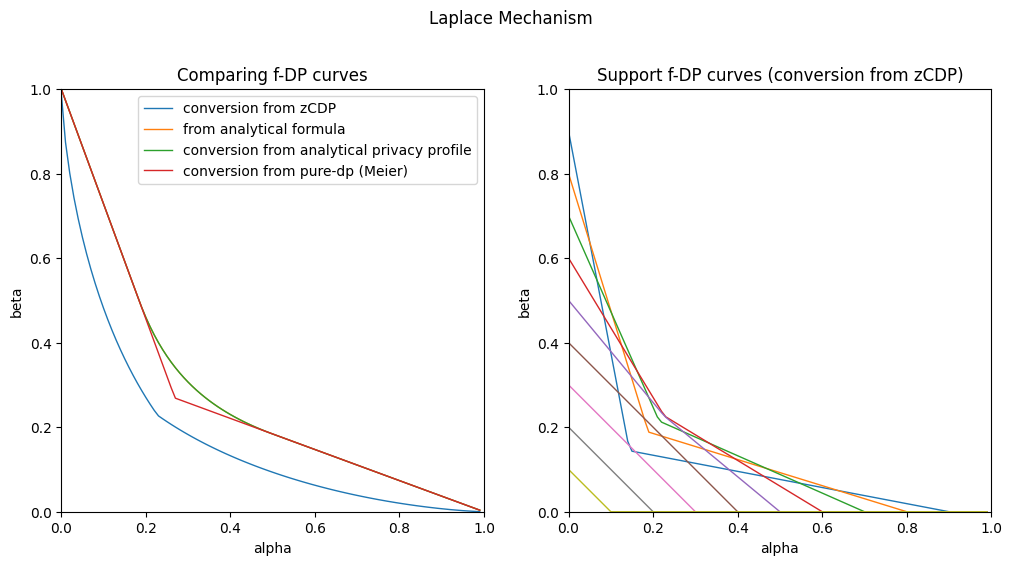

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Laplace Mechanism")

# from smdCurve vs analytical
ax1.plot(alphas, betas_laplace_001, label='conversion from zCDP', marker='', linewidth=1)
ax1.plot(alphas, betas_laplace_analytical, label='from analytical formula', marker='', linewidth=1)
ax1.plot(alphas, betas_laplace_privacy_profile, label='conversion from analytical privacy profile', marker='', linewidth=1)
ax1.plot(alphas, betas_laplace_meier_conversion, label='conversion from pure-dp (Meier)', marker='', linewidth=1)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title('Comparing f-DP curves')
ax1.legend()
ax1.set_aspect('equal')

# Support lines
for delta in np.arange(0.1, 1, 0.1):
    betas_eps_delta = [support_tradeoff(alpha, laplace_smd_curve.epsilon(delta), delta) for alpha in alphas]
    ax2.plot(alphas, betas_eps_delta, label=f"f-eps-delta({delta})", marker="", linewidth=1)
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title('Support f-DP curves (conversion from zCDP)')
#ax2.legend()
ax2.set_aspect('equal')

# TODO shift f-dp curves

plt.show()


In [20]:
deltas = np.arange(0.001, 1, 0.001)
priors = [0.1, 0.2, 0.5, 0.9, 0.99]
posteriors_laplace = []

tradeoff_laplace_eps1 = tradeoffCurve(smdCurveWrapper(laplace_smd_curve), deltas=deltas)

for prior in priors:
    post = [posterior(alpha, tradeoff_laplace_eps1, prior) for alpha in alphas]
    posteriors_laplace.append(post)


posteriors_analytical_laplace = []
for prior in priors:
    post = [posterior(alpha, get_tradeoff_laplace(scale=laplace_scale, sensitivity=count_sensitivity), prior) for alpha in alphas]
    posteriors_analytical_laplace.append(post)

posteriors_support_laplace = []
tradeoff_laplace_support = (lambda alpha: support_tradeoff(alpha, epsilon_laplace, 0))
for prior in priors:
    post = [posterior(alpha, tradeoff_laplace_support, prior) for alpha in alphas]
    posteriors_support_laplace.append(post)


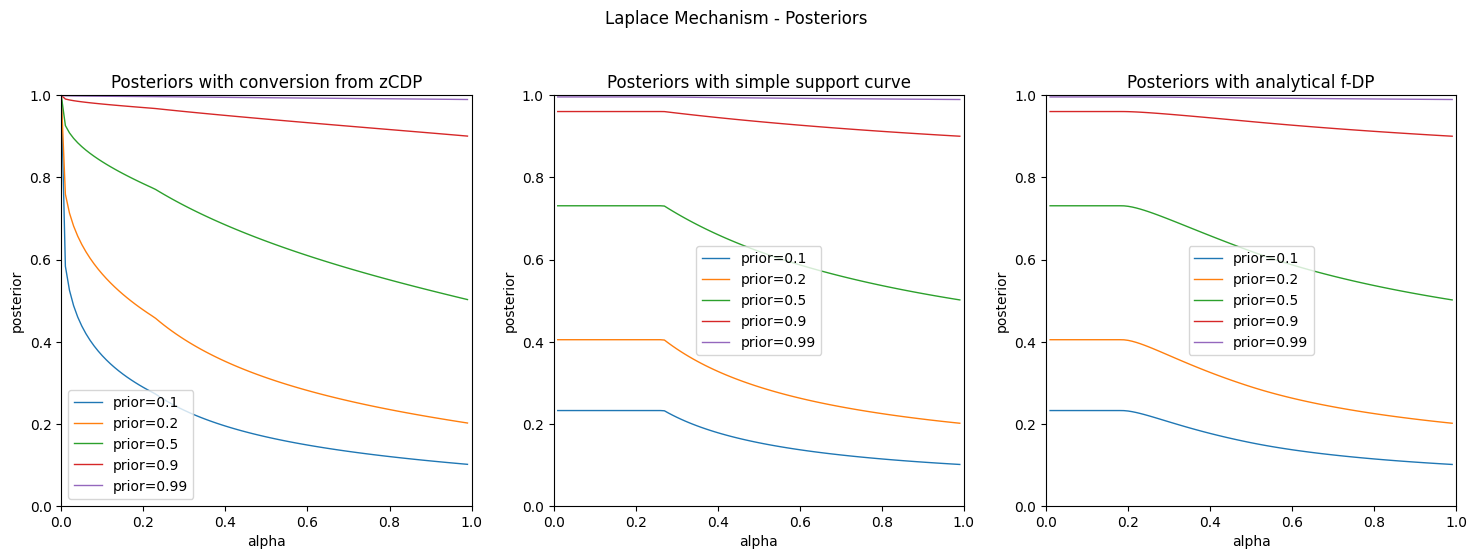

In [21]:
import matplotlib.pyplot as plt

fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Laplace Mechanism - Posteriors")

# from smdCurve vs analytical
for i in range(0, len(posteriors_laplace)):
    ax1.plot(alphas, posteriors_laplace[i], label=f"prior={priors[i]}", marker='', linewidth=1)

ax1.set_xlabel('alpha')
ax1.set_ylabel('posterior')
ax1.set_title('Posteriors with conversion from zCDP')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_aspect('equal')

# Support lines

ax2.set_xlabel('alpha')
ax2.set_ylabel('posterior')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title('Posteriors with analytical f-DP')
for i in range(0, len(posteriors_laplace)):
    ax2.plot(alphas, posteriors_analytical_laplace[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax2.legend()
ax2.set_aspect('equal')

ax3.set_xlabel('alpha')
ax3.set_ylabel('posterior')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_title('Posteriors with simple support curve')
for i in range(0, len(posteriors_laplace)):
    ax3.plot(alphas, posteriors_support_laplace[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax3.legend()
ax3.set_aspect('equal')

plt.show()

In [22]:
alphas = np.arange(0, 1, 0.01)
deltas = np.arange(0.001, 1, 0.001)
priors = [0.1, 0.2, 0.5, 0.9, 0.99]

tradeoff_laplace_eps1 = tradeoffCurve(smdCurveWrapper(laplace_smd_curve), deltas=deltas)

rrisk_laplace = []
for prior in priors:
    rrisk = [relative_risk(alpha, tradeoff_laplace_eps1, prior) for alpha in alphas]
    rrisk_laplace.append(rrisk)


rrisk_analytical_laplace = []
for prior in priors:
    rrisk = [relative_risk(alpha, get_tradeoff_laplace(scale=laplace_scale, sensitivity=count_sensitivity), prior) for alpha in alphas]
    rrisk_analytical_laplace.append(rrisk)

rrisk_support_laplace = []
for prior in priors:
    rrisk = [relative_risk(alpha, tradeoff_laplace_support, prior) for alpha in alphas]
    rrisk_support_laplace.append(rrisk)


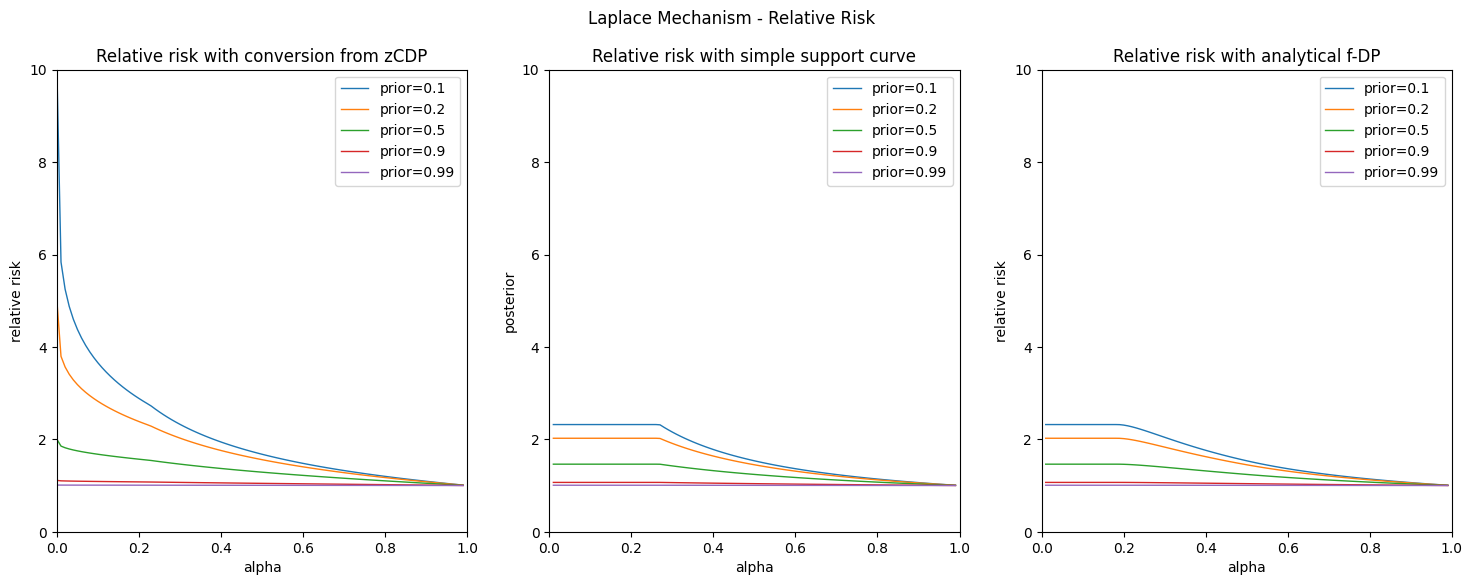

In [23]:
import matplotlib.pyplot as plt

fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Laplace Mechanism - Relative Risk")

# from smdCurve vs analytical
for i in range(0, len(rrisk_laplace)):
    ax1.plot(alphas, rrisk_laplace[i], label=f"prior={priors[i]}", marker='', linewidth=1)

ax1.set_xlabel('alpha')
ax1.set_ylabel('relative risk')
ax1.set_title('Relative risk with conversion from zCDP')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 10)

# Support lines

ax2.set_xlabel('alpha')
ax2.set_ylabel('relative risk')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 10)
ax2.set_title('Relative risk with analytical f-DP')
for i in range(0, len(rrisk_laplace)):
    ax2.plot(alphas, rrisk_analytical_laplace[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax2.legend()

ax3.set_xlabel('alpha')
ax3.set_ylabel('posterior')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 10)
ax3.set_title('Relative risk with simple support curve')
for i in range(0, len(rrisk_laplace)):
    ax3.plot(alphas, rrisk_support_laplace[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax3.legend()

plt.show()